In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from matplotlib import colors
from os import listdir
from os.path import isfile, join
import numpy as np

In [2]:
#soy_trade = pd.read_excel('data/soytrade.xlsx')

soy_trade = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/soytrade.csv?token=GHSAT0AAAAAACAIZJ3JI6FZBAGVWOJC63GWZCWBUCA')
country_size = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/countries_size.csv?token=GHSAT0AAAAAACAIZJ3J3FI7LT44R7AGRWGAZCWBV7Q')

In [3]:
soy_trade.head()

,Source,Target,1201 in 1000 USD,Year
0,ABW,COL,0.056,2000
1,ABW,COL,0.257,2003
2,ABW,NLD,2.916,2008
3,ABW,NLD,1.048,2009
4,ABW,USA,0.009,2008


In [4]:
country_size.head()

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Last Updated Date,01/03/2023,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0
4,Aruba,ABW,Surface area (sq. km),AG.SRF.TOTL.K2,NaN,180.0,180.0,180.0,180.0,180.0,...,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,180.0,NaN


In [5]:
country_size.drop([0,1,2], inplace=True)
country_size.columns = country_size.iloc[0]
country_size.drop([3], inplace=True)
country_size.drop(columns=['Indicator Name','Indicator Code', 'Country Name', 1960.0], inplace=True)

In [6]:
sizes = country_size.melt(id_vars=["Country Code"],
                  var_name="Year",
                  value_name="Area")

In [7]:
sizes["Year"] = sizes["Year"].apply(lambda x: int(x))

In [8]:
sizes.head()

,Country Code,Year,Area
0,ABW,1961,180.0
1,AFE,1961,15106741.0
2,AFG,1961,652860.0
3,AFW,1961,9166270.0
4,AGO,1961,1246700.0


In [9]:
soy_trade.rename(columns={"1201 in 1000 USD ": "trade_value"}, inplace=True)
soy_trade['ln_trade_value'] = soy_trade['trade_value'].apply(lambda x: np.log(x))

In [10]:
def add_attributes(trade_table, sizes_table, attribute_name):
    trade_table = trade_table.copy()
    sizes_table = sizes_table.copy()
    sizes_table = sizes_table[sizes_table["Year"] >= trade_table["Year"].min()] 
    trade_table.reset_index(drop=True, inplace=True)
    sizes_table.reset_index(drop=True, inplace=True)
    count = 0
    progress = 0
   
    for row in range(len(trade_table)):
        source_area_slice = sizes_table[(sizes_table["Country Code"] == trade_table.iloc[row, 0]) & (sizes_table["Year"] == trade_table.loc[row]["Year"])]
        target_area_slice = sizes_table[(sizes_table["Country Code"] == trade_table.iloc[row, 1]) & (sizes_table["Year"] == trade_table.loc[row]["Year"])]
        if len(source_area_slice) > 0:
            trade_table.at[row, f"Source {attribute_name}"] = source_area_slice.iloc[0][attribute_name]
        else: 
            trade_table.at[row, f"Source {attribute_name}"] = None

        if len(target_area_slice) > 0:
            trade_table.at[row, f"Target {attribute_name}"] = target_area_slice.iloc[0][attribute_name]
        else:
            trade_table.at[row, f"Target {attribute_name}"] = None
        count += 1
        current_progress = count / len(trade_table) * 100
        if current_progress >= 1:
            if current_progress >= progress + 10:
                progress = int(current_progress // 10) * 10
                print(f"{progress}% done")
    return trade_table


In [11]:
def append_sizes_to_trade_table(sizes_table, trade_table, attribute_name):
    count = 0
    progress = 0
   
    for row in range(len(soy_trade)):
        source_area_slice = sizes_table[(sizes["Country Code"] == trade_table.iloc[row, 0]) & (sizes["Year"] == trade_table.loc[row]["Year"])]
        target_area_slice = sizes_table[(sizes["Country Code"] == trade_table.iloc[row, 1]) & (sizes["Year"] == trade_table.loc[row]["Year"])]
        if len(source_area_slice) > 0:
            trade_table.at[row, f"Source {attribute_name}"] = source_area_slice.iloc[0][attribute_name]
        else: 
            trade_table.at[row, f"Source {attribute_name}"] = None
        if len(target_area_slice) > 0:
            trade_table.at[row, f"Target {attribute_name}"] = target_area_slice.iloc[0][attribute_name]
        else:
            trade_table.at[row, f"Target {attribute_name}"] = None
        count += 1
        current_progress = count / len(soy_trade) * 100
        if current_progress >= 1:
            if current_progress >= progress + 10:
                progress = int(current_progress // 10) * 10
                print(f"{progress}% done")

In [12]:
data = add_attributes(soy_trade, sizes, "Area")

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


In [13]:
data.head()

,Source,Target,trade_value,Year,ln_trade_value,Source Area,Target Area
0,ABW,COL,0.056,2000,-2.882404,180.0,1141750.0
1,ABW,COL,0.257,2003,-1.358679,180.0,1141750.0
2,ABW,NLD,2.916,2008,1.070213,180.0,41540.0
3,ABW,NLD,1.048,2009,0.046884,180.0,41540.0
4,ABW,USA,0.009,2008,-4.710531,180.0,9831510.0


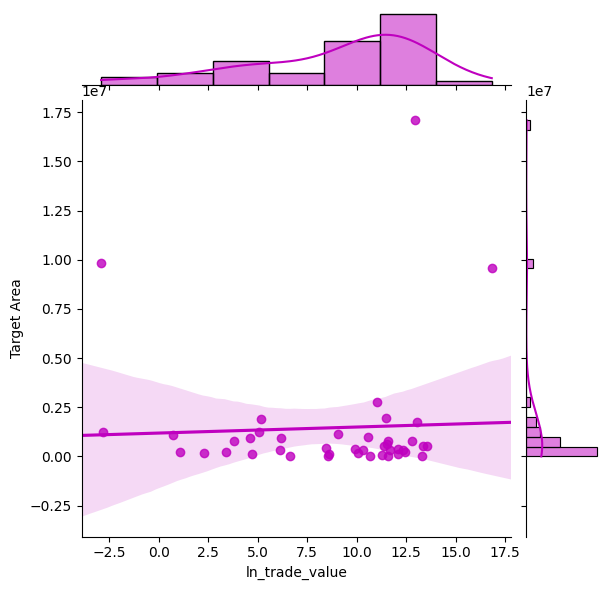

In [14]:
# relationship between trade value and area of brazilian partners   
g = sns.jointplot(x="ln_trade_value", y="Target Area", data=data[ (data['Source'] == 'BRA') & (data['Year'] == 2017)],
                  kind="reg", truncate=False,
                  color="m")

In [15]:
trade_brazil_2017 = data[ (data['Source'] == 'BRA') & (data['Year'] == 2017)]

In [16]:
import plotly.express as px

fig = px.scatter(trade_brazil_2017, y="Target Area", x="trade_value", text="Target", log_x=True, size_max=100, color="trade_value", trendline="ols")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Country Partner Area', title_x=0.5)
fig.show()

In [17]:
sum_trade = data[soy_trade['Year'] == 2020].groupby(['Source', 'Source Area'], as_index=False)['trade_value'].sum().sort_values(by=['trade_value'], ascending=False)

In [18]:
sum_trade.head()

,Source,Source Area,trade_value
13,BRA,8515770.0,2.856415e+07
100,USA,9831510.0,2.584804e+07
1,ARG,2780400.0,2.186202e+06
84,PRY,406752.0,2.146550e+06
16,CAN,9879750.0,2.004038e+06


In [19]:
fig = px.scatter(sum_trade, y="Source Area", x="trade_value", text="Source", log_x=True, size_max=100, color="trade_value", trendline="ols")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Exports x Source Area', title_x=0.5)
fig.show()

In [20]:
ex_rate = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/Exchange%20Rates.csv?token=GHSAT0AAAAAACAIZJ3J2IXNVLAXPYSOMDTOZCWB2RQ', skiprows=2)
ex_rate.rename({'Unnamed: 0': 'Country Code'}, inplace=True, axis=1)
ex_rate.head()

,Country Code,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,47.50,47.50,47.50,46.62,47.36,47.50,47.26,48.76,47.85,...,55.38,57.25,61.14,67.87,68.03,72.08,77.74,76.81,NaN,NaN
1,ALB,104.50,148.93,150.63,137.69,143.71,143.48,140.15,121.86,102.78,...,105.67,105.48,125.96,124.14,119.10,107.99,109.85,108.65,103.52,113.04
2,DZA,54.75,57.71,58.74,66.57,75.26,77.22,79.68,77.39,72.06,...,79.37,80.58,100.69,109.44,110.97,116.59,119.35,126.78,135.06,141.99
3,AND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.85,0.95
4,AGO,0.13,0.23,0.39,2.79,10.04,22.06,43.53,74.61,83.54,...,96.52,98.30,120.06,163.66,165.92,252.86,364.83,578.26,631.44,460.57


In [21]:
ex_rate = ex_rate.melt(id_vars=["Country Code"],
                  var_name="Year",
                  value_name="Exchange Rate")

In [22]:
ex_rate.head()

,Country Code,Year,Exchange Rate
0,AFG,1996,47.50
1,ALB,1996,104.50
2,DZA,1996,54.75
3,AND,1996,NaN
4,AGO,1996,0.13


In [23]:
ex_rate["Year"] = ex_rate["Year"].apply(lambda x: int(x))

In [24]:
data = add_attributes(soy_trade, ex_rate, "Exchange Rate")

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


In [25]:
data.head()

,Source,Target,trade_value,Year,ln_trade_value,Source Exchange Rate,Target Exchange Rate
0,ABW,COL,0.056,2000,-2.882404,1.79,"2,087.92"
1,ABW,COL,0.257,2003,-1.358679,1.79,"2,877.54"
2,ABW,NLD,2.916,2008,1.070213,1.79,NaN
3,ABW,NLD,1.048,2009,0.046884,1.79,NaN
4,ABW,USA,0.009,2008,-4.710531,1.79,1.00


In [26]:
print (data['Source Exchange Rate'].isnull().sum(), data['Target Exchange Rate'].isnull().sum())

7769 7567


In [27]:
# Subsitute nan of eu countries with EMU exchange rate
## EMU = European Monetary Union (Euro)
eu_countries = ['AUT', 'BEL', 'CYP', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'PRT', 'SVK', 'SVN', 'ESP']

for year in range(1999, data['Year'].max()+1):
    for country in eu_countries:
        ex_rate_value = ex_rate[(ex_rate["Year"] == year) & (ex_rate["Country Code"] == 'EMU')]['Exchange Rate'].values[0]
        data.loc[(data["Year"] == year) & (data["Source"].isin(eu_countries)), 'Source Exchange Rate'] = ex_rate_value
        data.loc[(data["Year"] == year) & (data["Target"].isin(eu_countries)), 'Target Exchange Rate'] = ex_rate_value

In [28]:
print (data['Source Exchange Rate'].isnull().sum(), data['Target Exchange Rate'].isnull().sum())

2415 1905


In [40]:
data['Source Exchange Rate'] = [0 if i is None else float(str(i).replace(",", "")) for i in data["Source Exchange Rate"]]
data['Target Exchange Rate'] = [0 if i is None else float(str(i).replace(",", "")) for i in data["Target Exchange Rate"]]

In [41]:
data["Ex Rate Source / Target"] = data["Source Exchange Rate"] / data["Target Exchange Rate"]
data["Ex Rate Target / Source"] = data["Target Exchange Rate"] / data["Source Exchange Rate"]

In [42]:
consumer_price = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/Consumer%20Price%20Index.csv?token=GHSAT0AAAAAACAIZJ3ILPT5RHHYRPV7PCQCZCWB3UA', skiprows=2)

consumer_price.rename({'Unnamed: 0': 'Country Code'}, inplace=True, axis=1)

In [43]:
consumer_price.head()

,Country Code,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.52,...,127.80,133.77,132.88,138.71,145.61,146.52,149.90,NaN,NaN,NaN
1,ALB,45.94,61.18,73.81,74.10,74.14,76.44,82.38,82.78,84.67,...,107.58,109.32,111.40,112.82,115.06,117.39,119.05,120.98,123.45,131.75
2,DZA,61.63,65.16,68.39,70.20,70.44,73.41,74.46,77.63,80.71,...,117.52,120.95,126.74,134.84,142.38,148.46,151.36,155.02,166.22,181.62
3,AGO,0.03,0.09,0.20,0.68,2.91,7.35,15.35,30.42,43.67,...,136.13,146.04,159.70,208.73,271.02,324.22,379.60,464.14,583.68,NaN
4,AIA,62.53,62.59,64.24,65.28,68.36,71.55,71.93,74.24,77.47,...,106.36,106.09,105.05,104.51,105.86,106.26,107.12,106.61,108.53,NaN


In [44]:
consumer_price = consumer_price.melt(id_vars=["Country Code"],
    var_name="Year",
    value_name="Consumer Price Index")

consumer_price.head()

,Country Code,Year,Consumer Price Index
0,AFG,1996,NaN
1,ALB,1996,45.94
2,DZA,1996,61.63
3,AGO,1996,0.03
4,AIA,1996,62.53


In [45]:
consumer_price["Year"] = consumer_price["Year"].apply(lambda x: int(x))

In [46]:
data = add_attributes(data, consumer_price, "Consumer Price Index")

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


In [47]:
data.head()

,Source,Target,trade_value,Year,ln_trade_value,Source Exchange Rate,Target Exchange Rate,Ex Rate Source / Target,Ex Rate Target / Source,Source Consumer Price Index,Target Consumer Price Index
0,ABW,COL,0.056,2000,-2.882404,1.79,2087.92,0.000857,1166.435754,72.03,58.22
1,ABW,COL,0.257,2003,-1.358679,1.79,2877.54,0.000622,1607.564246,79.36,71.61
2,ABW,NLD,2.916,2008,1.070213,1.79,0.68,2.632353,0.379888,100.1,97.58
3,ABW,NLD,1.048,2009,0.046884,1.79,0.72,2.486111,0.402235,97.96,98.74
4,ABW,USA,0.009,2008,-4.710531,1.79,1.00,1.790000,0.558659,100.1,98.74


In [49]:
data['Source Consumer Price Index'] = [0 if i is None else float(str(i).replace(",", "")) for i in data["Source Consumer Price Index"]]
data['Target Consumer Price Index'] = [0 if i is None else float(str(i).replace(",", "")) for i in data["Target Consumer Price Index"]]

In [50]:
data["exchange_rate ijt"] = data["Ex Rate Target / Source"] * (data["Source Consumer Price Index"] / data["Target Consumer Price Index"])

In [51]:
gdp_data = pd.read_csv('https://raw.githubusercontent.com/friedrich-henrique/datasets_soybeans_research/main/Gross%20Domestic%20Product.csv?token=GHSAT0AAAAAACAIZJ3J7OIU3VFDAPUG7342ZCWB4BQ',skiprows=2)

gdp_data.rename({'Unnamed: 0': 'Country Code'}, inplace=True, axis=1)

gdp_data = gdp_data.melt(id_vars=["Country Code"],
    var_name="Year",
    value_name="GDP")
gdp_data["Year"] = gdp_data["Year"].apply(lambda x: int(x))
gdp_data.head()

,Country Code,Year,GDP
0,AFG,1996,NaN
1,ALB,1996,NaN
2,AND,1996,NaN
3,AGO,1996,NaN
4,AIA,1996,71.78


In [52]:
data = add_attributes(data, gdp_data, "GDP")

10% done
20% done
30% done
40% done
50% done
60% done
70% done
80% done
90% done
100% done


In [78]:
data['Source GDP'] = [0 if i is None else float(str(i).replace(",", "")) for i in data["Source GDP"]]
data['Target GDP'] = [0 if i is None else float(str(i).replace(",", "")) for i in data["Target GDP"]]

In [82]:
data.replace(0, np.nan, inplace=True)

In [83]:
data["level of output ijt"] = (np.log(data["Source GDP"]) + np.log(data["Target GDP"])) / 2

In [84]:
data.dropna().head()

,Source,Target,trade_value,Year,ln_trade_value,Source Exchange Rate,Target Exchange Rate,Ex Rate Source / Target,Ex Rate Target / Source,Source Consumer Price Index,Target Consumer Price Index,exchange_rate ijt,Source GDP,Target GDP,level of output ijt
8,AFG,PAK,456.769,2017,6.124178,68.03,105.46,0.645079,1.550198,145.61,156.91,1.438560,129.48,150.17,4.937647
9,AFG,PAK,2.309,2018,0.836815,72.08,121.82,0.591693,1.690067,146.52,164.88,1.501871,132.16,155.94,4.966742
10,AGO,NAM,33.614,2017,3.514943,165.92,13.31,12.465815,0.080219,271.02,146.03,0.148881,93.11,161.85,4.810226
11,AGO,NAM,5.437,2019,1.693227,364.83,14.45,25.247751,0.039607,379.60,157.97,0.095176,90.51,170.58,4.822332
13,AGO,STP,0.237,2017,-1.439695,165.92,21.74,7.632015,0.131027,271.02,171.61,0.206928,93.11,165.29,4.820742


In [86]:
fig = px.scatter(data.dropna(), y="trade_value", x="level of output ijt", color="trade_value", trendline="ols")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Trade x Output', title_x=0.5)
fig.show()

In [87]:
fig = px.scatter(data.dropna(), y="trade_value", x="level of output ijt", log_y=True, size_max=100, color="trade_value", trendline="ols")
fig.update_traces(textposition='top center')
fig.update_layout(title_text='Trade x GDP', title_x=0.5)
fig.show()

In [64]:
trade = pd.DataFrame()
trade["exports"] = data.groupby(["Source"]).sum().sort_values(by=['trade_value'], ascending=False)["trade_value"]
trade["imports"] = data.groupby(["Target"]).sum().sort_values(by=['trade_value'], ascending=False)["trade_value"]

In [65]:
trade.sort_values(by=['exports'], ascending=False).head()

,exports,imports
Source,,
USA,4.042988e+08,6.076918e+06
BRA,3.937798e+08,3.181201e+06
ARG,6.313352e+07,1.208813e+07
PRY,3.293041e+07,2.151925e+05
CAN,2.991672e+07,3.844911e+06


In [66]:
trade["ln_exports"] = np.log(trade["exports"])
trade["ln_imports"] = np.log(trade["imports"])

In [67]:
trade.ln_exports.min(), trade.ln_exports.max()

trade.ln_imports.min(), trade.ln_imports.max()

(0.883767540168595, 20.069866110473917)

posx and posy should be finite values
posx and posy should be finite values


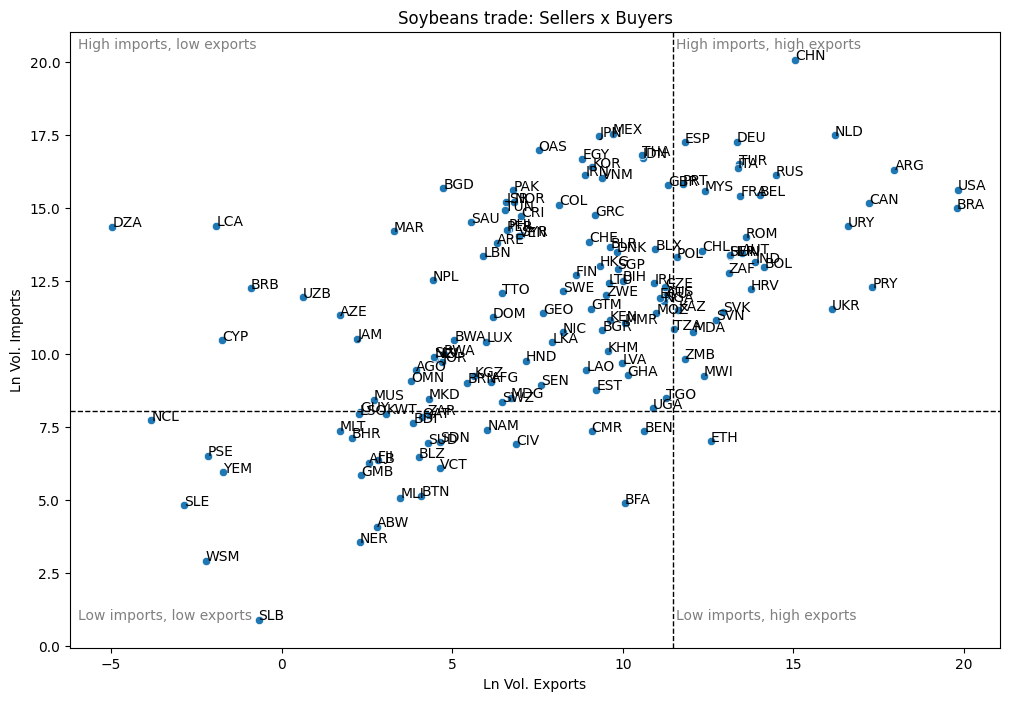

In [68]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=trade, x='ln_exports', y='ln_imports')
plt.title(f"Soybeans trade: Sellers x Buyers")
plt.xlabel("Ln Vol. Exports")
plt.ylabel("Ln Vol. Imports")

#Country names
for i in range(trade.shape[0]):
          plt.text(trade.ln_exports[i], y=trade.ln_imports[i], s=trade.iloc[i].name, mouseover=True, fontsize=10)

# Benchmark Mean values          
plt.axhline(y=trade.ln_exports.mean(), color='k', linestyle='--', linewidth=1)           
plt.axvline(x=trade.ln_imports.mean(), color='k',linestyle='--', linewidth=1) 

#Quadrant Marker          
plt.text(x=trade.ln_exports.min()-1, y=trade.ln_imports.min(), s="Low imports, low exports",alpha=0.5,fontsize=10, color='black')
plt.text(x=trade.ln_exports.min()-1, y=trade.ln_imports.max()+0.4, s="High imports, low exports",alpha=0.5,fontsize=10, color='black')
plt.text(x=trade.ln_imports.mean()+0.1, y=trade.ln_imports.min(), s="Low imports, high exports", alpha=0.5,fontsize=10, color='black')
plt.text(x=trade.ln_imports.mean()+0.1, y=trade.ln_imports.max()+0.4, s="High imports, high exports", alpha=0.5,fontsize=10, color='black')

plt.show()